In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # A pythonic file-system interface to Google Cloud Storage
from tqdm.autonotebook import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
import math
import copy
from scipy.interpolate import griddata
import seawater as sw
from mpl_toolkits.basemap import Basemap, cm, maskoceans

In [3]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.2.26:45981
distributed.scheduler - INFO -   dashboard at:                    :35157
distributed.scheduler - INFO - Receive client connection: Client-3fe0644c-446a-11ea-8333-c2fa316413c6
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.2.26:45981 Dashboard: /user/0000-0002-3606-2575/proxy/35157/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.32.4.14:45033
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.14:45033
distributed.core - INFO - Starting established connection


In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
def func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid): 
    #### Latitude Bounds ####
    Lat_regrid_1D= np.zeros ((lat_n_regrid+1));
    Lat_bound_regrid = np.zeros ((lat_n_regrid+1,2)); Lat_bound_regrid[0,0]=-90;  Lat_bound_regrid[0,1]=Lat_bound_regrid[0,0] + ( (180/lat_n_regrid) /2 ); Lat_regrid_1D[0]=(Lat_bound_regrid[0,0]+Lat_bound_regrid[0,1])/2
    for ii in range(1,lat_n_regrid+1):
        Lat_bound_regrid[ii,0]=Lat_bound_regrid[ii-1,1]
        Lat_bound_regrid[ii,1]=Lat_bound_regrid[ii,0] +  (180/lat_n_regrid)
        Lat_regrid_1D[ii]=(Lat_bound_regrid[ii,0]+Lat_bound_regrid[ii,1])/2
    Lat_bound_regrid[-1,1]=90;  Lat_regrid_1D[-1]=(Lat_bound_regrid[-1,0]+Lat_bound_regrid[-1,1])/2
    #### Longitude Bounds ####
    Lon_regrid_1D= np.zeros ((lon_n_regrid));
    Lon_bound_regrid = np.zeros ((lon_n_regrid,2)); Lon_bound_regrid[0,0]=0;  Lon_bound_regrid[0,1]=Lon_bound_regrid[0,0] + (360/lon_n_regrid); Lon_regrid_1D[0]=(Lon_bound_regrid[0,0]+Lon_bound_regrid[0,1])/2
    for ii in range(1,lon_n_regrid):
        Lon_bound_regrid[ii,0]=Lon_bound_regrid[ii-1,1]
        Lon_bound_regrid[ii,1]=Lon_bound_regrid[ii,0] +  (360/lon_n_regrid)
        Lon_regrid_1D[ii]=(Lon_bound_regrid[ii,0]+Lon_bound_regrid[ii,1])/2
    
    return Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid


def func_regrid(Data_orig, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D):    
    
    Lon_orig[Lon_orig < 0] +=360
    if np.ndim(Lon_orig)==1: # If the GCM grid is not curvlinear
        Lon_orig,Lat_orig=np.meshgrid(Lon_orig, Lat_orig)
        
    lon_vec = np.asarray(Lon_orig)
    lat_vec = np.asarray(Lat_orig)
    lon_vec = lon_vec.flatten()
    lat_vec = lat_vec.flatten()
    coords=np.squeeze(np.dstack((lon_vec,lat_vec)))

    Data_orig=np.squeeze(Data_orig)
    if Data_orig.ndim==2:#this is for 2d regridding
        data_vec = np.asarray(Data_orig)
        if np.ndim(data_vec)>1:
            data_vec = data_vec.flatten()
        Data_regrid = griddata(coords, data_vec, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
        return np.asarray(Data_regrid)
    if Data_orig.ndim==3:#this is for 3d regridding
        Data_regrid=[]
        for d in range(len(Data_orig)):
            z = np.asarray(Data_orig[d,:,:])
            if np.ndim(z)>1:
                z = z.flatten()
            zi = griddata(coords, z, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
            Data_regrid.append(zi)
        return np.asarray(Data_regrid)
    
#### running mean calculation ####
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [53]:
def func_plot2Dcolor_contourf(P_Var_x1, P_Var_y1, P_Var_z1, P_range, P_xlable, P_ylable, P_title, P_unit, P_cmap, P_invert_yaxis):

    fig=plt.figure()
    im = plt.contourf(P_Var_x1, P_Var_y1, P_Var_z1, P_range, cmap=P_cmap, extend='both')

    if P_invert_yaxis == 'invert_yaxis':
        plt.gca().invert_yaxis()
    plt.xticks(fontsize = 26); plt.yticks(fontsize = 26)
    plt.xlabel(P_xlable, fontsize=18)
    plt.ylabel(P_ylable, fontsize=18)
    plt.title(P_title, fontsize=18)
    #m = Basemap( projection='cyl', lon_0=0) # This is only added to be used for the cbar in the next line
    #cbar = m.colorbar(im,"right", size="3%", pad="2%", extend='max') # extend='both' will extend the colorbar in both sides (upper side and down side)
    cbar = plt.colorbar(im)
    cbar.set_label(P_unit)
    cbar.ax.tick_params(labelsize=18) 
    mng = plt.get_current_fig_manager()
    #mng.window.showMaximized() # Maximizes the plot window to save figures in full
        
    return fig

In [6]:
lat_n_regrid, lon_n_regrid = 180, 360 # Number of Lat and Lon elements in the regridded data
lon_min_regrid, lon_max_regrid = 0, 360 # Min and Max value of Lon in the regridded data
lat_min_regrid, lat_max_regrid = -90, 90 # Min and Max value of Lat in the regridded data

Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid)
Lon_regrid_2D, Lat_regrid_2D = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)

In [7]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [8]:
def func_load_ds_uri(uri):
    """
    Load data for given uri
    """
    gcs = gcsfs.GCSFileSystem(token='anon') # GCSFS will attempt to use your default gcloud credentials
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
GCM_name = 'GFDL-CM4'

In [10]:
df_plt = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao') & (df.activity_id == 'CMIP') & (df.experiment_id == 'piControl')& (df.source_id==GCM_name)]
df_plt = df_plt[ df_plt['grid_label'] == 'gr']
#run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
#run_counts
uri_thetao = df_plt[(df_plt.source_id == GCM_name)].zstore.values[0]
uri_thetao

'gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/thetao/gr/'

In [11]:
ds_thetao = func_load_ds_uri(uri_thetao)

In [15]:
ds_thetao.lat

<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    axis:           Y
    bounds:         lat_bnds
    cell_methods:   time: point
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [76]:
da_thetao_ws = ds_thetao.thetao.sel(lon=slice(300.5, 359.5), lat=slice(-89.5,-59.5))
da_thetao_ws

<xarray.DataArray 'thetao' (time: 6000, lev: 35, lat: 31, lon: 59)>
dask.array<getitem, shape=(6000, 35, 31, 59), dtype=float32, chunksize=(25, 35, 31, 59), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -62.5 -61.5 -60.5 -59.5
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lon      (lon) float64 300.5 301.5 302.5 303.5 ... 355.5 356.5 357.5 358.5
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

In [77]:
month_no = 9
yrs_no = np.int(len(da_thetao_ws.time)/12)
da_thetao_ws_sept = []

for t in tqdm(range(yrs_no)):
    #print('MLD calc - Year: ', t+1)
    data = da_thetao_ws.isel(time= 12*t+month_no-1 ).values
    da_thetao_ws_sept.append(data)

In [79]:
da_thetao_ws_sept_ave = np.nanmean( np.nanmean(da_thetao_ws_sept, axis=3) , axis=2)

In [80]:
year_start = 1
year_end = 500
GCM = 'GFDL-CM4'

Depths= ds_thetao.lev.values

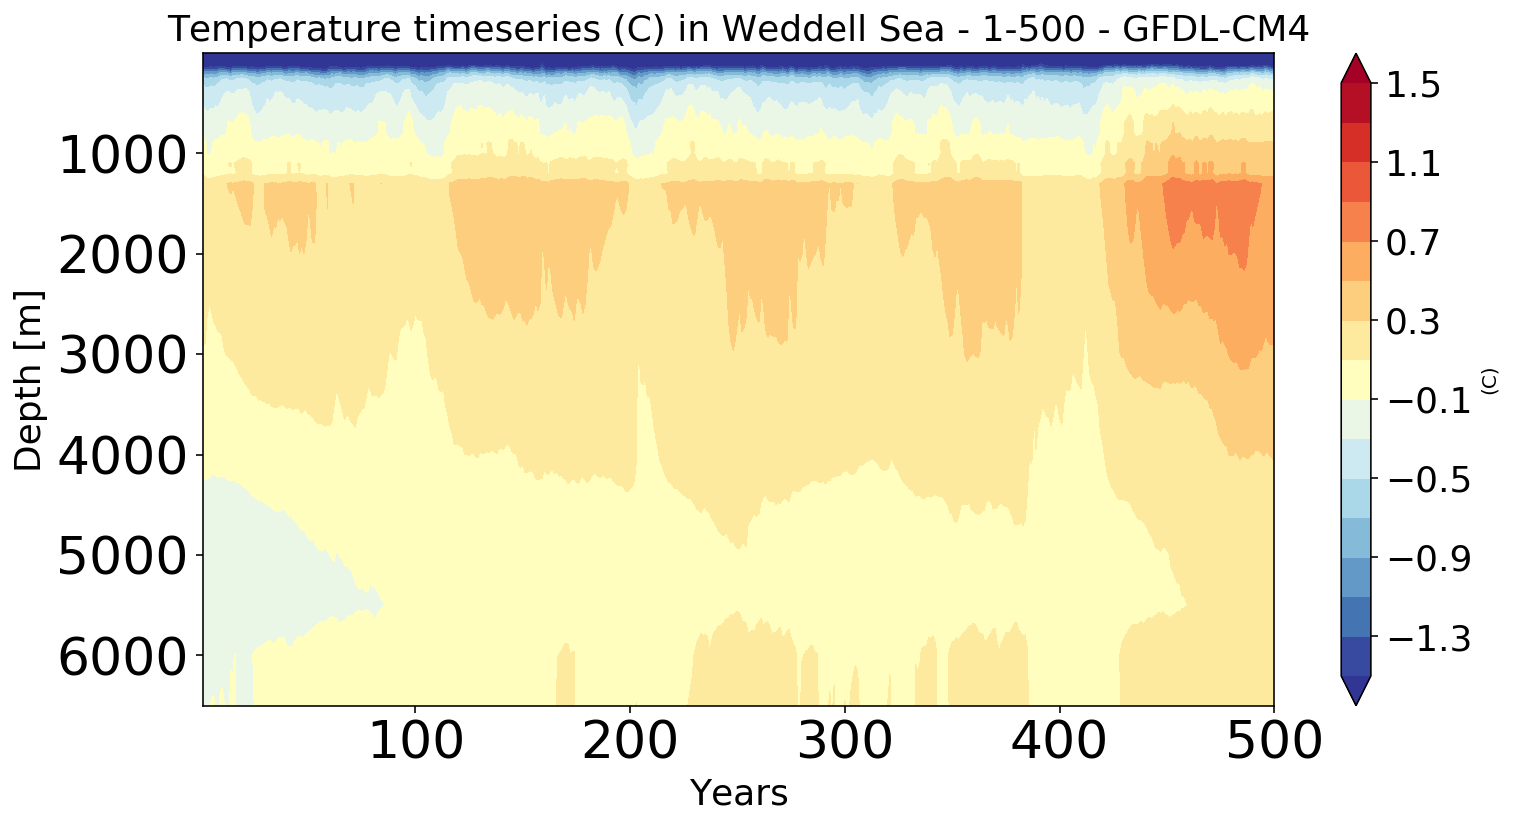

In [81]:
P_Var_x1=np.linspace(year_start,year_end,year_end-year_start+1)
P_Var_y1=Depths
P_Var_z1=np.transpose(da_thetao_ws_sept_ave)
P_range=np.linspace(-1.5, 1.5, 16)
P_xlable='Years'  ;P_ylable='Depth [m]';  P_unit = '(C)'
P_title='Temperature timeseries (C) in Weddell Sea - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)
fig=func_plot2Dcolor_contourf(P_Var_x1, P_Var_y1, P_Var_z1, P_range, P_xlable, P_ylable, P_title, P_unit, plt.cm.RdYlBu_r, 'invert_yaxis')
#l = plt.axhline(y=500)
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_NOR.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [40]:
da_thetao_ross = ds_thetao.thetao.sel(lon=slice(160.5, 230.5), lat=slice(-89.5,-59.5))
da_thetao_ross

<xarray.DataArray 'thetao' (time: 6000, lev: 35, lat: 30, lon: 71)>
dask.array<getitem, shape=(6000, 35, 30, 71), dtype=float32, chunksize=(25, 35, 30, 71), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -63.5 -62.5 -61.5 -60.5
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lon      (lon) float64 160.5 161.5 162.5 163.5 ... 227.5 228.5 229.5 230.5
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

In [41]:
month_no = 9
yrs_no = np.int(len(da_thetao_ross.time)/12)
da_thetao_ross_sept = []

for t in tqdm(range(yrs_no)):
    #print('MLD calc - Year: ', t+1)
    data = da_thetao_ross.isel(time= 12*t+month_no-1 ).values
    da_thetao_ross_sept.append(data)

In [78]:
da_thetao_ross_sept_ave = np.nanmean( np.nanmean(da_thetao_ross_sept, axis=3) , axis=2)

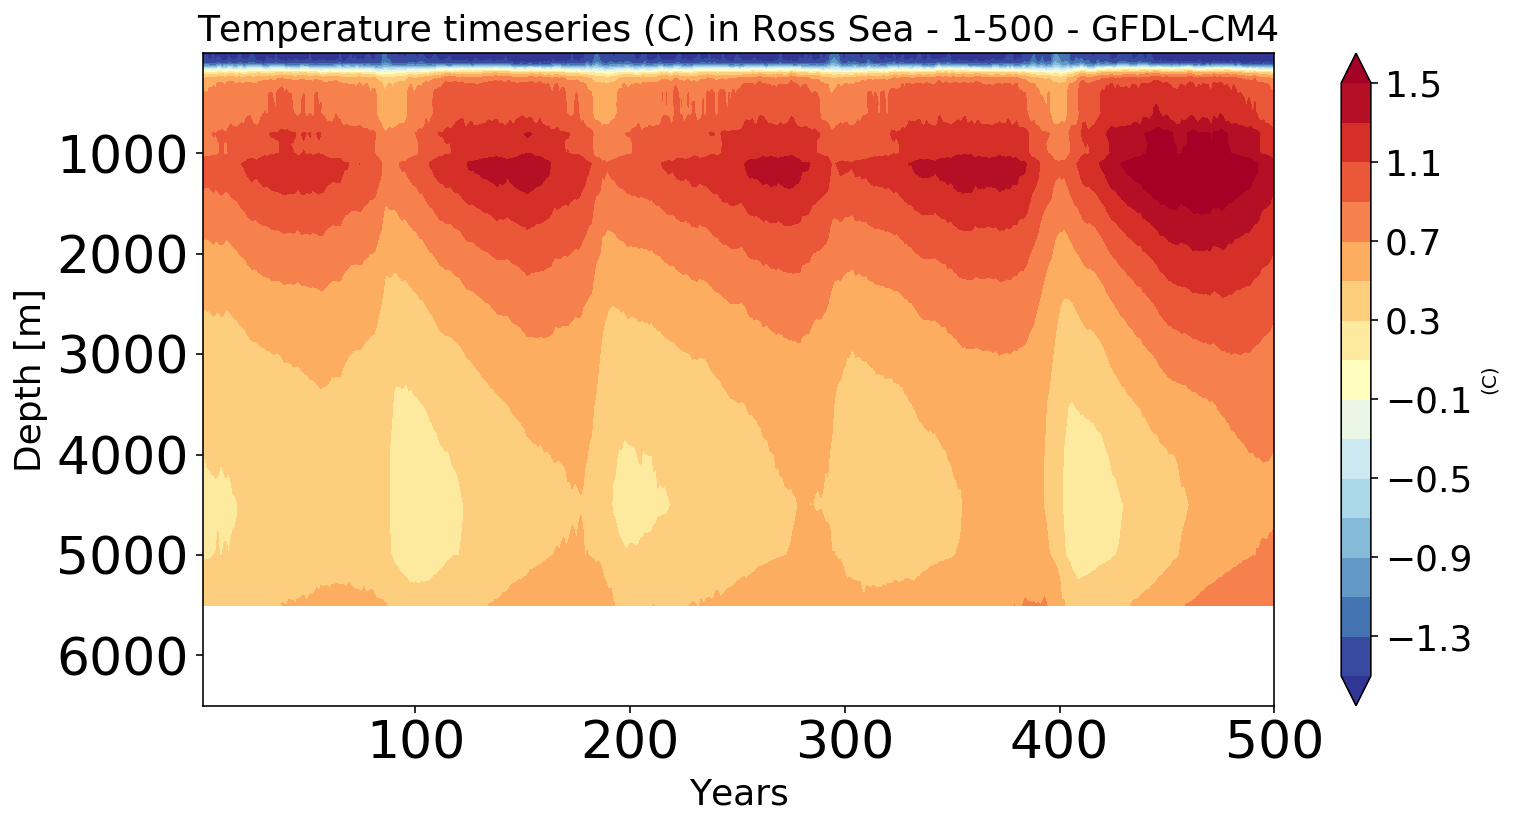

In [74]:
P_Var_x1=np.linspace(year_start,year_end,year_end-year_start+1)
P_Var_y1=Depths[0:30]
P_Var_z1=np.transpose(da_thetao_ross_sept_ave[:,0:30])
P_range=np.linspace(-1.5, 1.5, 16)
P_xlable='Years'  ;P_ylable='Depth [m]';  P_unit = '(C)'
P_title='Temperature timeseries (C) in Ross Sea - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)
fig=func_plot2Dcolor_contourf(P_Var_x1, P_Var_y1, P_Var_z1, P_range, P_xlable, P_ylable, P_title, P_unit, plt.cm.RdYlBu_r, 'invert_yaxis')
#l = plt.axhline(y=500)
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_NOR.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

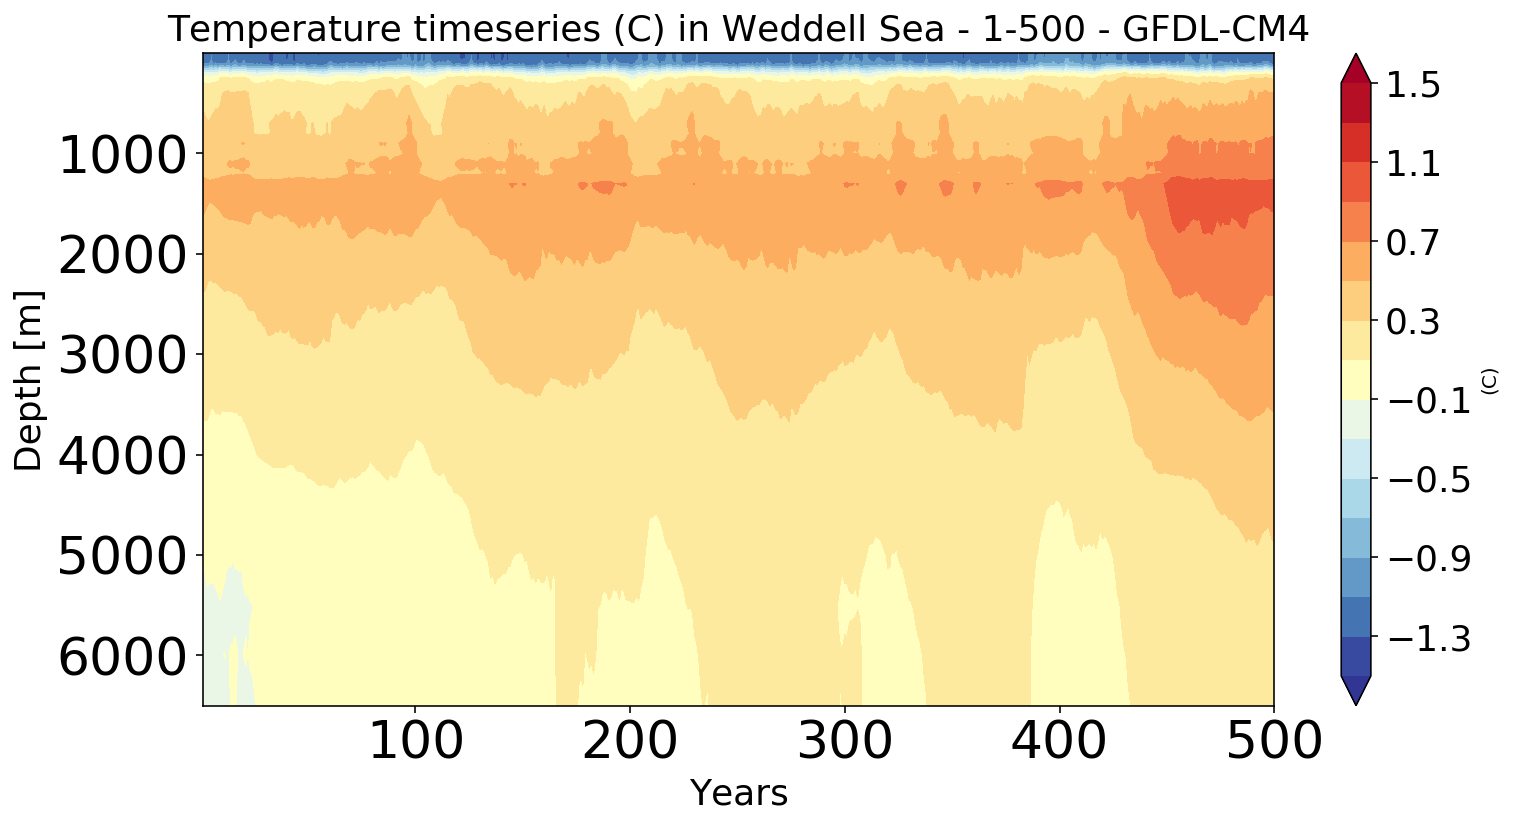

In [75]:
P_Var_x1=np.linspace(year_start,year_end,year_end-year_start+1)
P_Var_y1=Depths
P_Var_z1=np.transpose(da_thetao_ws_sept_ave)
P_range=np.linspace(-1.5, 1.5, 16)
P_xlable='Years'  ;P_ylable='Depth [m]';  P_unit = '(C)'
P_title='Temperature timeseries (C) in Weddell Sea - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM)
fig=func_plot2Dcolor_contourf(P_Var_x1, P_Var_y1, P_Var_z1, P_range, P_xlable, P_ylable, P_title, P_unit, plt.cm.RdYlBu_r, 'invert_yaxis')
#l = plt.axhline(y=500)
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_NOR.png', format='png', dpi=300, transparent=True, bbox_inches='tight')